# CS640 Final Project CV Testing & Visualization

In [6]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
#from keras.utils.np_utils import *
#from keras import utils as np_utils
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, Dense, BatchNormalization, Conv2D, MaxPool2D, GlobalMaxPool2D, Dropout
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow import keras
# from tensorflow.keras.utils import plot_model
from keras.utils.vis_utils import plot_model

In [22]:
IM_HEIGHT = 198
IM_WIDTH = 198
BATCH_SIZE = 297

def delete_invalid_data(df):
    length = len(df)
    drop_list = []
    for i in range(length):
        r = df.iloc[i]
        image_url = r['img_path']
        try:
            img = Image.open(image_url)
        except IOError:
            drop_list.append(i)
    return df.drop(drop_list)

# Race Prediction

In [23]:
df = pd.read_csv('clean_dataset.csv', usecols=[1, 2, 8])
df['race'] = pd.to_numeric(df['race'])
print(len(df))
df = delete_invalid_data(df)
df.reset_index(drop=True, inplace=True)
train_dataset = df.sample(frac=0.8,ignore_index=True)
test_dataset = df.drop(train_dataset.index)
val_dataset = test_dataset.sample(frac=0.5)
test_dataset = test_dataset.drop(val_dataset.index)
val_dataset.reset_index(drop=True, inplace=True)
test_dataset.reset_index(drop=True, inplace=True)
print(len(test_dataset))

3051
297


In [24]:
def race_gen(df, for_training, picSize, batchSize):
    races, images, rgb_images = [], [], []
    length = len(df)
    while True:
        for i in range(length):
            r = df.iloc[i]
            race, age, image = r['race'], r['age'], r['img_path']
            img = Image.open(image)
            img = img.resize(picSize, Image.BILINEAR)
            rgb = np.array(img) / 255.0
            img = img.convert('L')
            img = np.array(img) / 255.0
#             races.append(race - 1)
            races.append(to_categorical((race - 1), 4))
#             ages.append(age)
#             ages.append(to_categorical(age, 2))
            images.append(img)
            rgb_images.append(rgb)
            if len(images) >= batchSize:
                yield np.array(images), np.array(races), np.array(rgb_images)
                images, races, rgb_images = [], [], []
        if not for_training:
            break

In [25]:
picSize = (IM_WIDTH, IM_HEIGHT)
new_model = keras.models.load_model("race_model_checkpoint")
# keras.utils.plot_model(new_model, to_file='model.png', show_shapes=True)

testgen = race_gen(test_dataset, False, picSize, BATCH_SIZE)
x_test, race_true, x_rgb = next(testgen)
race_pred = new_model.predict_on_batch(x_test)
race_true = race_true.argmax(axis=-1)
race_pred = race_pred.argmax(axis=-1)
print("Classification report for race")
print(classification_report(race_true, race_pred))

Classification report for race
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        30
           1       0.00      0.00      0.00        24
           2       0.00      0.00      0.00        10
           3       0.78      1.00      0.88       233

    accuracy                           0.78       297
   macro avg       0.20      0.25      0.22       297
weighted avg       0.62      0.78      0.69       297



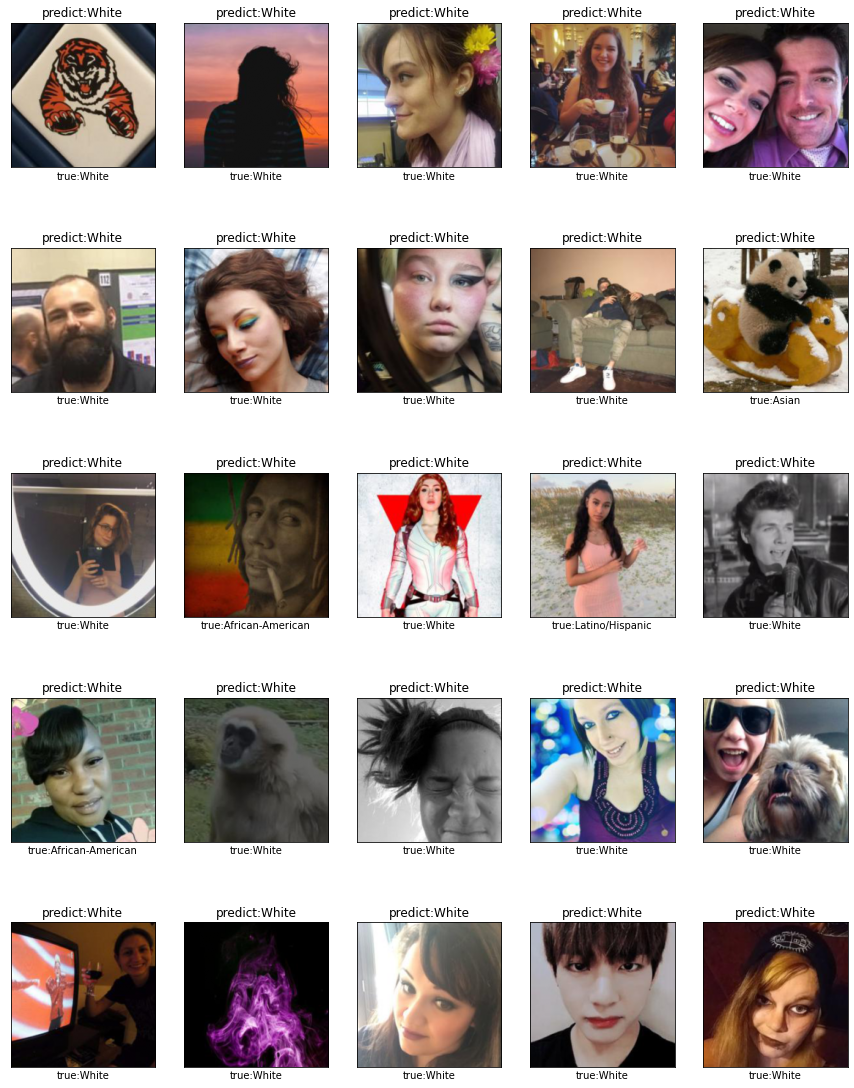

In [11]:
import math
ID_RACE_MAP = {0: 'African-American', 1: 'Latino/Hispanic', 2: 'Asian', 3: 'White'}
n = 25
random_indices = np.random.permutation(n)
n_cols = 5
n_rows = math.ceil(n / n_cols)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 20))
for i, img_idx in enumerate(random_indices):
    ax = axes.flat[i]
    ax.imshow(x_rgb[img_idx])
    ax.set_title('predict:{}'.format(ID_RACE_MAP[race_pred[img_idx]]))
    ax.set_xlabel('true:{}'.format(ID_RACE_MAP[race_true[img_idx]]))
    ax.set_xticks([])
    ax.set_yticks([])

## Age Prediction

In [16]:
df_age = pd.read_csv('clean_dataset_1145.csv', usecols=[0, 6])
df_age['age'] = pd.to_numeric(df_age['age'])
print(len(df_age))
df_age = delete_invalid_data(df_age)
df_age.reset_index(drop=True, inplace=True)
train_dataset = df_age.sample(frac=0.8,ignore_index=True)
test_dataset = df_age.drop(train_dataset.index)
val_dataset = test_dataset.sample(frac=0.5)
test_dataset = test_dataset.drop(val_dataset.index)
val_dataset.reset_index(drop=True, inplace=True)
test_dataset.reset_index(drop=True, inplace=True)

1041


In [17]:
def age_gen(df, for_training, picSize, batchSize):
    ages, images = [], []
    length = len(df)
    while True:
        for i in range(length):
            r = df.iloc[i]
            age, image = r['age'], r['img_path']
            img = Image.open(image)
            img = img.resize(picSize, Image.BILINEAR)
            img = img.convert('L')
            img = np.array(img) / 255.0
#             ages.append(age)
            ages.append(to_categorical(age, 2))
            images.append(img)
            if len(images) >= batchSize:
                yield np.array(images), np.array(ages)
                images, ages = [], []
        if not for_training:
            break

In [18]:
picSize = (IM_WIDTH, IM_HEIGHT)
new_model = keras.models.load_model("age_model_checkpoint")


testgen = age_gen(test_dataset, False, picSize, 104)
x_test, age_true= next(testgen)
age_pred = new_model.predict_on_batch(x_test)
age_true = age_true.argmax(axis=-1)
age_pred = age_pred.argmax(axis=-1)
print("Classification report for race")
print(classification_report(age_true, age_pred))

Classification report for race
              precision    recall  f1-score   support

           0       0.69      0.99      0.81        69
           1       0.83      0.14      0.24        35

    accuracy                           0.70       104
   macro avg       0.76      0.56      0.53       104
weighted avg       0.74      0.70      0.62       104



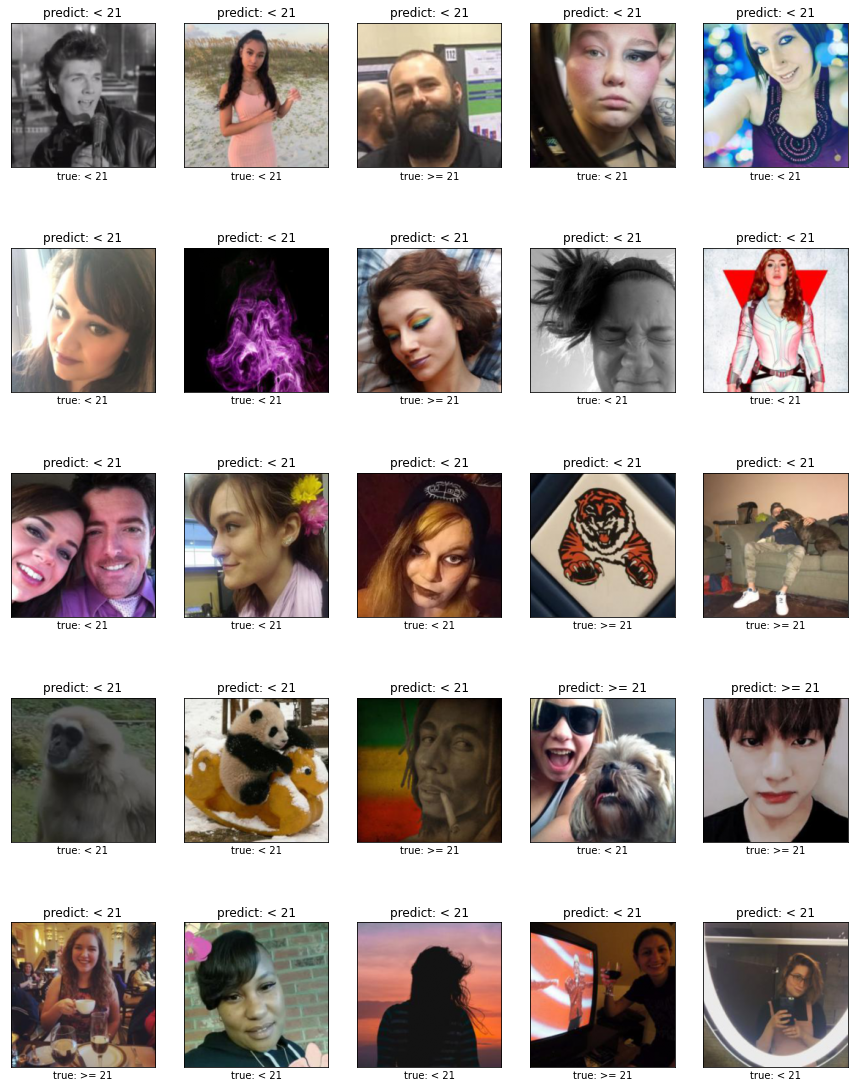

In [19]:
import math
ID_AGE_MAP = {0: ' < 21', 1: ' >= 21'}
n = 25
random_indices = np.random.permutation(n)
n_cols = 5
n_rows = math.ceil(n / n_cols)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 20))
for i, img_idx in enumerate(random_indices):
    ax = axes.flat[i]
    ax.imshow(x_rgb[img_idx])
    ax.set_title('predict:{}'.format(ID_AGE_MAP[age_pred[img_idx]]))
    ax.set_xlabel('true:{}'.format(ID_AGE_MAP[age_true[img_idx]]))
    ax.set_xticks([])
    ax.set_yticks([])